# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.math import reduce_mean
from tensorflow import convert_to_tensor

from model import plot_history, get_Xi_yi, get_X_y, get_folds, train_test_split_fold, MinMaxNormalization
from cleaning import get_clean_bikes_dataframe


2022-12-06 16:05:24.101324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 16:05:24.435754: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 16:05:24.454484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 16:05:24.454513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

# Key cells

In [2]:
colab = False
station_sequence = False
diff = False

In [3]:
INPUT_LENGTH = int(1*12) # 1 hours * 12 stamps per hour

In [4]:
N_TRAIN = 10000 # number_of_sequences_train
N_TEST =  5000 # number_of_sequences_test

In [5]:
if colab :
    from google.colab import drive
    drive.mount('/content/drive')

# Data Loading

In [6]:
if colab :
    bikes_df = pd.read_csv('bikes_df.csv').drop(columns='Unnamed: 0')
else :
    bikes_df = get_clean_bikes_dataframe()

DataFrame successfully loaded from ~/.velov/data/cleaned/all_stations_hist.csv.


In [7]:
step = 5
step_str = f'{step}min'

bikes_df=bikes_df.sort_values(by="time")
bikes_df['time']=pd.to_datetime(bikes_df['time'])
bikes_df = bikes_df.resample(step_str, on='time').mean()

if diff:
    for col in bikes_df.columns:
        bikes_df[col] = bikes_df[col].diff()
    bikes_df.dropna(inplace=True)

In [8]:
# To verify normal distribution of diffs

#if diff:
#    bins = np.linspace(-39.75,39.75,num=80)
#    diffs = np.array(bikes_df).reshape(bikes_df.shape[0]*bikes_df.shape[1])
#    sns.histplot(diffs, bins=bins);

# Folding

In [9]:
FOLD_LENGTH = bikes_df.shape[0] # int(24 * 12 * 61) # 24 hours per day, 12 stamps per hour, 61 days
    
FOLD_STRIDE = 1 #int(24 * 12 * 7) # 1 week

TRAIN_TEST_RATIO = 0.7

print(FOLD_LENGTH, FOLD_STRIDE, INPUT_LENGTH)

43718 1 12


In [10]:
bikes_folds = get_folds(bikes_df, FOLD_LENGTH, FOLD_STRIDE)
bikes_fold = bikes_folds[0]

There are 1 folds.


In [11]:
(bikes_fold_train, bikes_fold_test) = train_test_split_fold(bikes_fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

The train split contains 30603 observations and the test split 13115 observations.


In [12]:
OUTPUT_LENGTH = INPUT_LENGTH
SEQUENCE_STRIDE = 1

# Train/Test split


In [13]:
X_train_bikes, y_train_bikes = get_X_y(bikes_fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_bikes, y_test_bikes = get_X_y(bikes_fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

X_train_bikes.shape, y_train_bikes.shape, X_test_bikes.shape, y_test_bikes.shape

((10000, 12, 430), (10000, 12, 430), (5000, 12, 430), (5000, 12, 430))

In [14]:
if station_sequence == True :
    # Pour passer en v Station = Sequence
    X_train_bikes = np.array(pd.DataFrame(X_train_bikes[0]).transpose())
    X_test_bikes = np.array(pd.DataFrame(X_test_bikes[0]).transpose())
    y_train_bikes = np.array(pd.DataFrame(y_train_bikes[0]).transpose())
    y_test_bikes = np.array(pd.DataFrame(y_test_bikes[0]).transpose())

    X_train_bikes = X_train_bikes.reshape((430,INPUT_LENGTH,1))
    X_test_bikes = X_test_bikes.reshape((430,INPUT_LENGTH,1))
    y_train_bikes = y_train_bikes.reshape((430,OUTPUT_LENGTH))
    y_test_bikes = y_test_bikes.reshape((430,OUTPUT_LENGTH))

    print(X_train_bikes.shape, y_train_bikes.shape, X_test_bikes.shape, y_test_bikes.shape) 


# Baseline Model 

In [15]:
if not diff:
    y_base_bikes = []
    for i in range(y_test_bikes.shape[0]):
        y_base_bikes.append([X_test_bikes[i,-1:,:]]*y_test_bikes.shape[1])

    y_base_bikes = np.array(y_base_bikes).reshape((y_test_bikes.shape[0],y_test_bikes.shape[1],y_test_bikes.shape[2]))
    y_base_bikes.shape

In [16]:
if diff:
    mae = round(np.abs(y_test_bikes).mean(),4)
else :
    mae = round(np.abs(y_test_bikes-y_base_bikes).mean(),4)
mae

0.9317

[0.25, 0.43, 0.58, 0.71, 0.82, 0.93, 1.03, 1.12, 1.21, 1.29, 1.37, 1.45]


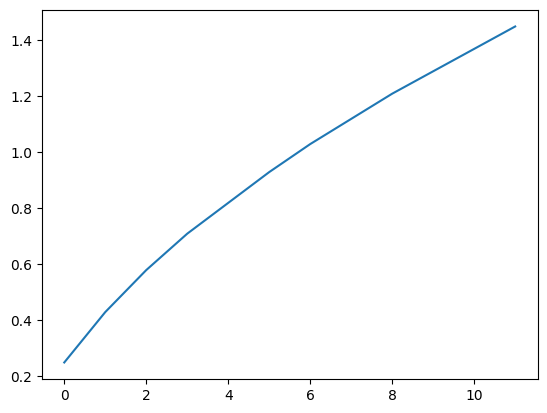

In [17]:
maes = []

for i in range(y_test_bikes.shape[1]):
    if diff:
        maes.append(np.round(np.abs(y_test_bikes[:,i,:]).mean(),4))
    else:
        maes.append(np.round(np.abs(y_test_bikes[:,i,:]-y_base_bikes[:,i,:]).mean(),2))

print(maes)
plt.plot(maes);

# Scaling and scoring the Baseline on scaled

In [18]:
if not diff:
    scaler = MinMaxNormalization()
    scaler.fit_transform(X_train_bikes)
    scaler.transform(y_train_bikes)
    scaler.transform(X_test_bikes)
    scaler.transform(y_test_bikes)
    print(f"X_train : Shape {X_train_bikes.shape}, min {X_train_bikes.min()}, max {X_train_bikes.max()}")
    print(f"y_train : Shape {y_train_bikes.shape}, min {y_train_bikes.min()}, max {y_train_bikes.max()}")
    print(f"X_test : Shape {X_test_bikes.shape}, min {X_test_bikes.min()}, max {X_test_bikes.max()}")
    print(f"y_test : Shape {y_test_bikes.shape}, min {y_test_bikes.min()}, max {y_test_bikes.max()}")

X_train : Shape (10000, 12, 430), min 0.0, max 1.0
y_train : Shape (10000, 12, 430), min 0.0, max 1.0
X_test : Shape (5000, 12, 430), min 0.0, max 15.0
y_test : Shape (5000, 12, 430), min 0.0, max 15.0


In [19]:
if not diff:
    scaler.transform(y_base_bikes)
    scaled_base_mae = round(np.abs(y_test_bikes-y_base_bikes).mean(),4)
    scaled_base_mae
    print(scaled_base_mae)


0.0471


# Custom Loss to penalize more later predictions (and keep the baseline for early preditctions)

In [20]:
import tensorflow

a = tensorflow.constant([[1, 2], [3, 4]])                 
b = tensorflow.add(a, 1)
c = a.numpy()
for i in range(c.shape[0]):
    if i ==0 :
        c[i] = (a[i]-b[i]) **2
    else :
        c[i] = -(a[i]-b[i]) **2


type(convert_to_tensor(c))   

2022-12-06 16:06:04.400835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-06 16:06:04.401541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 16:06:04.401783: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-06 16:06:04.401910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-06 16:06:04.402006: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

tensorflow.python.framework.ops.EagerTensor

In [21]:
low_threshold = 12
high_threshold = 12
penalization = 4

#def make_custom_mse(low_threshold:int=1_000_000_000_000, high_threshold:int=1_000_000_000_000):
#    def custom_mse(y_true, y_pred):
#        tmp = np.zeros(shape=(y_true.shape[0],y_true.shape[1]))
#        for i in range(y_true.shape[0]):
#            if i < low_threshold:
#                tmp[i] = ((y_true[i]-y_pred[i])**2)
#            elif i < high_threshold :
#                tmp[i] = ((y_true[i]-y_pred[i])**2) * penalization
#            else :
#                pass # Custom loss still returns 0       
#        return reduce_mean(reduce_mean(tmp, axis=-1),axis=0)
#    return custom_mse

def make_custom_mae(batch_size:int, low_threshold:int=1_000_000_000_000, high_threshold:int=1_000_000_000_000):
    def custom_mae(y_true, y_pred):
        tmp = np.zeros(shape=y_true.shape)
        for i in range(y_true.shape[1]):
            if i < high_threshold :
                tmp[i] = np.abs(y_true[i]-y_pred[i])
            else :
                pass # Custom loss still returns 0       
        return reduce_mean(reduce_mean(tmp, axis=-1),axis=1)
    return custom_mae

def make_custom_mse(batch_size:int, low_threshold:int=1_000_000_000_000, high_threshold:int=1_000_000_000_000):
    def custom_mse(y_true, y_pred):
        print(y_true.shape, type(y_true))
        print(y_pred.shape, type(y_pred))
        error = (y_true - y_pred).numpy()
        print(error.shape, type(error))
        for i in range(error.shape[1]):
            if i < low_threshold:
                error[:,i,:] = error[:,i,:] ** 2
            elif i < high_threshold :
                error[:,i,:] = error[:,i,:] ** 2 * penalization
            else :
                pass # Keeps error to 0   
        np_error=convert_to_tensor(error)
        print(reduce_mean(reduce_mean(reduce_mean(np_error, axis=-1),axis=1),axis=0))    
        return reduce_mean(reduce_mean(reduce_mean(np_error, axis=-1),axis=1),axis=0)
    return custom_mse

#    return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

In [22]:
# Cell to test the validity of the custom loss function (do not forget to adjust thresholds)

from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

test_int = 32

y_cust_loss_test_a = convert_to_tensor(y_test_bikes[:test_int,:,:])
y_cust_loss_test_b = convert_to_tensor(y_train_bikes[:test_int,:,:])

mse_base = MeanSquaredError()
mae_base = MeanAbsoluteError()
custom_mse = make_custom_mse(test_int)
custom_mae = make_custom_mae(test_int)

#print(f"MSE Base: {mse_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MSE Custom: {custom_mse(y_cust_loss_test_a, y_cust_loss_test_b)} / MAE Base: {mae_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MAE Custom: {custom_mae(y_cust_loss_test_a, y_cust_loss_test_b)}")
print(f"MSE Base: {mse_base(y_cust_loss_test_a, y_cust_loss_test_b)} vs MSE Custom: {custom_mse(y_cust_loss_test_a, y_cust_loss_test_b)}")


(32, 12, 430) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 12, 430) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 12, 430) <class 'numpy.ndarray'>
tf.Tensor(0.23055295681715487, shape=(), dtype=float64)
MSE Base: 0.23055295646190643 vs MSE Custom: 0.23055295681715487


# Modelling

### Loss function parameters 

In [29]:
from tensorflow import enable_eager_execution

enable_eager_execution()

low_t = 3
high_t = 12
batch_size= 32

ImportError: cannot import name 'enable_eager_execution' from 'tensorflow' (/home/arnaud/.pyenv/versions/lewagon/lib/python3.10/site-packages/tensorflow/__init__.py)

### Not Diff

In [30]:
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps = decay_steps, decay_rate = decay_rate,)

def init_model(X_train, y_train):

    model = Sequential([
        layers.GRU(units=256, input_shape = (X_train.shape[1],X_train.shape[2]), activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        #layers.GRU(units=256, activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        #layers.Dense(256,activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(512,activation = 'relu'),
        #layers.Dropout(0.2),
        layers.Dense(64,activation = 'relu'),
        layers.Dense(64,activation = 'relu'),
        layers.Dense(y_train.shape[2], activation='linear')  
    ])

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                #loss = 'mse',
                loss=make_custom_mse(batch_size,low_threshold=low_t, high_threshold=high_t),
                #loss = 'mse',
                run_eagerly=True,
                metrics=['mae'])
    return model

### Diff

In [25]:
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps = decay_steps, decay_rate = decay_rate,)

def init_diff_model(X_train, y_train):
    
    normalizer = Normalization()
    normalizer.adapt(X_train)

    model = Sequential([
        normalizer,
        layers.GRU(units=64, activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        layers.GRU(units=64, activation='tanh', return_sequences=True),
        #layers.Dropout(0.2),
        #layers.Dense(256,activation = 'relu'),
        #layers.Dropout(0.2),
        #layers.Dense(512,activation = 'relu'),
        #layers.Dropout(0.2),
        #layers.Dense(64,activation = 'relu'),
        #layers.Dense(64,activation = 'relu'),
        layers.Dense(y_train.shape[2], activation='linear')  
    ])
    
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss=make_custom_mse(batch_size, low_threshold=low_t, high_threshold=high_t),
                metrics=['mae'])
    return model

### All

In [31]:
if diff:
    model = init_diff_model(X_train_bikes, y_train_bikes)
else :
    model = init_model(X_train_bikes, y_train_bikes)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 12, 256)           528384    
                                                                 
 dense_8 (Dense)             (None, 12, 512)           131584    
                                                                 
 dense_9 (Dense)             (None, 12, 64)            32832     
                                                                 
 dense_10 (Dense)            (None, 12, 64)            4160      
                                                                 
 dense_11 (Dense)            (None, 12, 430)           27950     
                                                                 
Total params: 724,910
Trainable params: 724,910
Non-trainable params: 0
_________________________________________________________________


In [32]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model,X,y):
    es = EarlyStopping(patience=6,restore_best_weights = True)
    history = model.fit(X,y,epochs = 200,callbacks=es,batch_size=batch_size, validation_split=0.3)
    return(model,history)

In [33]:
model = init_model(X_train_bikes,y_train_bikes)
if model.trainable:
    print('yes')
model,history = fit_model(model,X_train_bikes,y_train_bikes)


yes
Epoch 1/200
(32, 12, 430) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 12, 430) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 12, 430) <class 'numpy.ndarray'>
tf.Tensor(0.8936571, shape=(), dtype=float32)


ValueError: No gradients provided for any variable: (['gru_3/gru_cell_3/kernel:0', 'gru_3/gru_cell_3/recurrent_kernel:0', 'gru_3/gru_cell_3/bias:0', 'dense_12/kernel:0', 'dense_12/bias:0', 'dense_13/kernel:0', 'dense_13/bias:0', 'dense_14/kernel:0', 'dense_14/bias:0', 'dense_15/kernel:0', 'dense_15/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'gru_3/gru_cell_3/kernel:0' shape=(430, 768) dtype=float32, numpy=
array([[-0.01287425, -0.05915565,  0.05448381, ..., -0.04105786,
        -0.03436672, -0.06026015],
       [ 0.04116546, -0.06449559,  0.0357568 , ..., -0.03792779,
        -0.04182598, -0.01543674],
       [ 0.0272619 , -0.02648311, -0.0411903 , ...,  0.00887268,
         0.05816408,  0.02435903],
       ...,
       [-0.06003624,  0.03474361, -0.02908725, ...,  0.00924098,
        -0.05271982, -0.00667275],
       [ 0.01508685,  0.07069223, -0.06592907, ...,  0.00637092,
         0.02403337, -0.02720478],
       [-0.04757689,  0.04897212, -0.01957598, ...,  0.05892297,
         0.05272418, -0.06980672]], dtype=float32)>), (None, <tf.Variable 'gru_3/gru_cell_3/recurrent_kernel:0' shape=(256, 768) dtype=float32, numpy=
array([[-0.00683689,  0.00316491,  0.00961637, ..., -0.00434522,
        -0.01514333, -0.0136807 ],
       [ 0.03708032,  0.04792964, -0.03503641, ...,  0.00947174,
         0.06453106, -0.03310475],
       [-0.03512521, -0.02990579,  0.0219357 , ..., -0.0556965 ,
         0.0583851 ,  0.00339582],
       ...,
       [-0.01941029, -0.04113177,  0.01054165, ...,  0.02984609,
         0.00104155, -0.00221556],
       [-0.01656208, -0.00618625, -0.01054408, ...,  0.02607044,
        -0.01945095, -0.02501416],
       [-0.02686219, -0.01206619,  0.00906326, ..., -0.03667138,
        -0.00268356, -0.01064636]], dtype=float32)>), (None, <tf.Variable 'gru_3/gru_cell_3/bias:0' shape=(2, 768) dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>), (None, <tf.Variable 'dense_12/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.0130277 ,  0.00321265, -0.04043899, ...,  0.05040506,
        -0.0354216 ,  0.03843697],
       [ 0.0804828 ,  0.06487771, -0.00522052, ...,  0.02169728,
         0.06789789, -0.03342547],
       [-0.03205793,  0.07107747, -0.05314656, ...,  0.04165173,
         0.02039347, -0.0363195 ],
       ...,
       [ 0.05158473,  0.01887035,  0.07156672, ..., -0.07699816,
        -0.01141454,  0.03816245],
       [ 0.00191315, -0.07828682,  0.023756  , ..., -0.00687396,
         0.05598869,  0.00234789],
       [-0.06497207,  0.01194758,  0.01467954, ..., -0.04575363,
        -0.07408514,  0.08161248]], dtype=float32)>), (None, <tf.Variable 'dense_12/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_13/kernel:0' shape=(512, 64) dtype=float32, numpy=
array([[-0.07210515, -0.04208164, -0.01537008, ..., -0.03926056,
        -0.04262703,  0.05510822],
       [-0.08970193,  0.05222486, -0.09077895, ...,  0.04613119,
        -0.03058117,  0.07353857],
       [-0.0262756 , -0.02724896, -0.05519781, ..., -0.09395223,
        -0.07780199,  0.0321821 ],
       ...,
       [ 0.0919084 , -0.08143421, -0.03269356, ..., -0.05772825,
        -0.10138556,  0.0841126 ],
       [ 0.03772317, -0.00545394,  0.06995833, ...,  0.09889565,
        -0.01432043,  0.0914235 ],
       [-0.07294454,  0.09274386, -0.08418158, ...,  0.02000897,
        -0.02644878, -0.02433512]], dtype=float32)>), (None, <tf.Variable 'dense_13/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_14/kernel:0' shape=(64, 64) dtype=float32, numpy=
array([[-0.05344129,  0.19483007, -0.0956948 , ...,  0.07158925,
         0.09791501,  0.19989975],
       [-0.00748065,  0.02490938,  0.10120444, ..., -0.0254952 ,
         0.02535398, -0.17695737],
       [ 0.02466264, -0.13076149,  0.03245151, ...,  0.05050121,
        -0.21139683,  0.19589551],
       ...,
       [ 0.19507806, -0.09338144,  0.03142872, ..., -0.13842033,
         0.0719438 ,  0.16772027],
       [ 0.15588276,  0.10744332, -0.00079127, ...,  0.08451049,
        -0.17913559, -0.12002781],
       [ 0.10160978, -0.10647231,  0.03402089, ..., -0.13638318,
        -0.16595082, -0.03452189]], dtype=float32)>), (None, <tf.Variable 'dense_14/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'dense_15/kernel:0' shape=(64, 430) dtype=float32, numpy=
array([[ 0.0899467 , -0.0146186 , -0.06258017, ...,  0.06223807,
        -0.05925765,  0.08667789],
       [ 0.09192395, -0.03424241,  0.02728096, ..., -0.03231142,
        -0.03632401,  0.10933776],
       [-0.08123775, -0.03436919, -0.092627  , ...,  0.10994954,
         0.03340469,  0.10392143],
       ...,
       [ 0.04607482, -0.01402343,  0.06310631, ..., -0.03748193,
        -0.017712  , -0.09981883],
       [-0.01875834, -0.00677897,  0.03142615, ...,  0.07638927,
         0.05536477, -0.01379815],
       [-0.07182113, -0.00666606,  0.0667316 , ...,  0.10801321,
         0.10461591, -0.04115717]], dtype=float32)>), (None, <tf.Variable 'dense_15/bias:0' shape=(430,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.], dtype=float32)>)).

In [ ]:
res =model.evaluate(X_test_bikes,y_test_bikes)

157/157 [==============================] - 3s 20ms/step - loss: 0.4052 - mae: 0.2811


In [ ]:
y_pred = model.predict(X_test_bikes)

157/157 [==============================] - 3s 19ms/step


0.2811
[0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28]


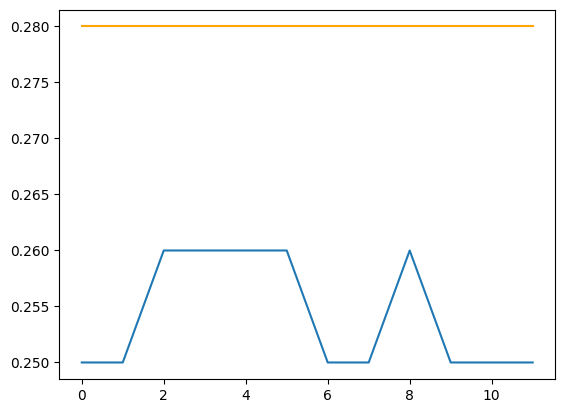

In [ ]:

if not diff :
    scaler.inverse_transform(y_test_bikes)
    scaler.inverse_transform(y_pred)        

model_mae = round(np.abs(y_test_bikes-y_pred).mean(),4)

model_maes = []
for i in range(y_pred.shape[1]):
    model_maes.append(np.abs(y_test_bikes[:,i,:]-y_pred[:,i,:]).mean())

print(model_mae)
print(model_maes)
plt.plot(model_maes, color='orange');
plt.plot(maes);

In [ ]:
y_pred.shape

(5000, 12, 430)

array([<AxesSubplot:title={'center':'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot:title={'center':'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

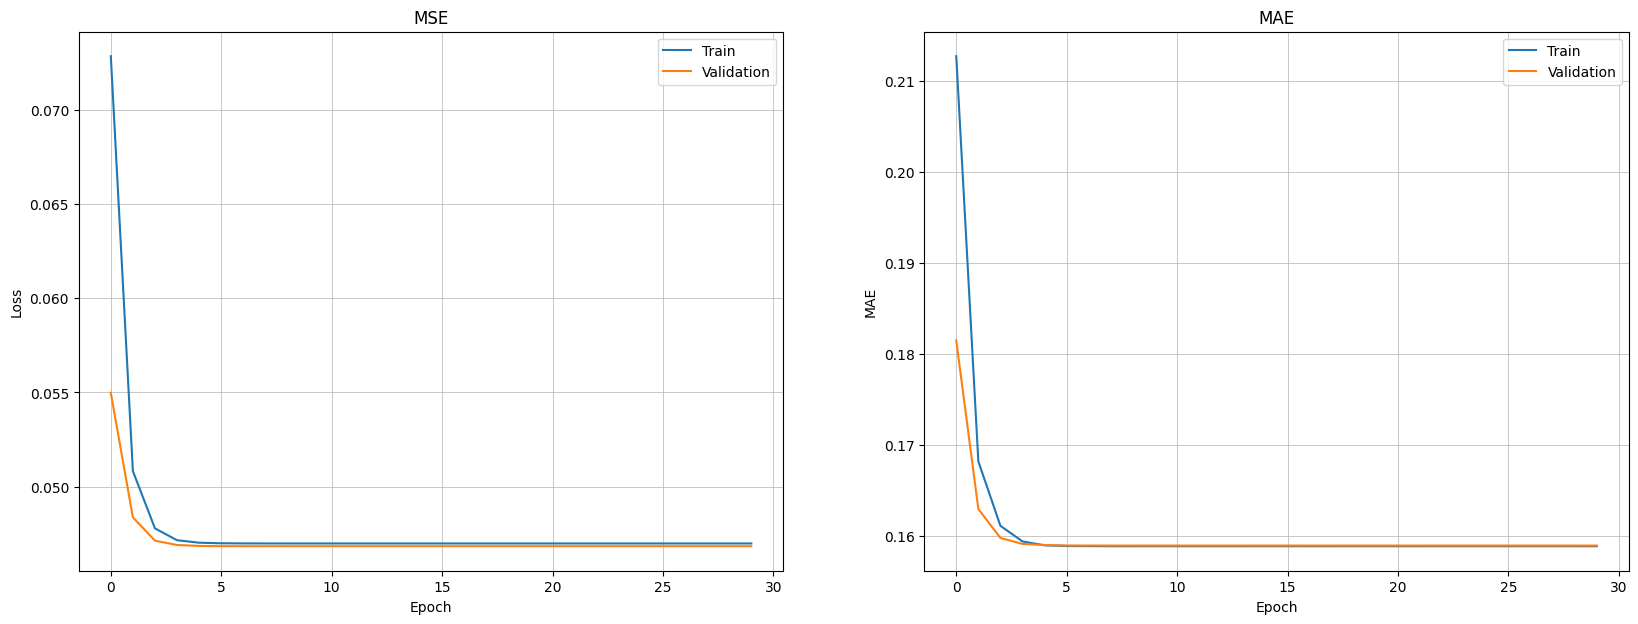

In [ ]:
plot_history(history)